# Context

Imagine that you are a data analyst working for the The Johns Hopkins Hospital.
Your team is asked to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine, which patients have high stroke risk will allow your doctors to advice them and their families how to act in case of an emergency.
As you are about to start working on your project your team's manager approaches you with a request.
She has read an article that AI can predict all sorts of things that required dedicated sensors before - [Tesla doesn't use a rain sensor for its automatic wiper system](https://electrek.co/2019/10/14/tesla-deep-rain-neural-net-automatic-wipers/).
Following the example of Elon Musk she proposes her brilliant idea to save money - to replace all blood pressure monitors, glucose monitor, and scales with AI.
She argues that this would save the hospital millions of dollars every year.
She wants you to create three additional machine learning models to predict the hypertension, average glucose level, and BMI of the patient.
You are not 100% convinced of this idea and try to explain why it won't work, but she is insistent and you promise to try anyway - this will give you a great opportunity to practice your new machine learning skills and have metrics about how accurate predictions for these variables can be using state-of-the-art machine learning models.



# 1 Setup 

In [ ]:
!pip install optuna
!pip install catboost   
!pip install shap

In [ ]:
# Data analysis and calculation
import pandas as pd
import numpy as np
import additional_functions

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ROCAUC

# Statistical modules
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
import collections

# Machine learning prediction
import optuna
import shap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import model_selection


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Warnings handling and import
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
path = "/content/healthcare-dataset-stroke-data.csv"
stroke_df = pd.read_csv(path)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Description of data set:

**id**: unique identifier

**gender**: 
* Male
* Female 
* Other

**age**: age of the patient

**hypertension**: 
* 0 if the patient doesn't have hypertension
* 1 if the patient has hypertension

**heart_disease**: 
* 0 if the patient doesn't have any heart diseases 
* 1 if the patient has a heart disease

**ever_married**: 
* No 
* Yes

**work_type**: 
* Children 
* Govt_jov 
* Never_worked 
* Private 
* Self-employed

**Residence_type**: 
* Rural 
* Urban

**avg_glucose_level**:  average glucose level in blood

**bmi**: body mass index

**smoking_status**: 
* Formerly smoked 
* Never smoked 
* Smokes 
* Unknown

**stroke**: 
* 1 if the patient had a stroke 
* 0 if not

**Note**: "Unknown" in smoking_status means that the information is unavailable for this patient

# 2 Data Cleaning

In [ ]:
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

We see that all numbers are float or int, so there is no need for further action.

In [ ]:
stroke_df.shape

(5110, 12)

In this data set, we have 5110 rows and 12 columns

In [ ]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
stroke_df["bmi"] = stroke_df["bmi"].fillna(
    stroke_df.groupby("age")["bmi"].transform("mean")
)

In [ ]:
stroke_df[stroke_df.duplicated("id")].head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


There are no duplicates

In [ ]:
stroke_eda = stroke_df.copy()

For the EDA part, I created a copy of the stroke dataset to remove the missing values, but in the predictions part, I will try to fill them in.

In [ ]:
Q1 = stroke_eda.quantile(0.1)
Q3 = stroke_eda.quantile(0.9)
IQR = Q3 - Q1

outliers_df = (stroke_eda < (Q1 - 1.5 * IQR)) | (stroke_eda > (Q3 + 1.5 * IQR))

((stroke_eda < (Q1 - 1.5 * IQR)) | (stroke_eda > (Q3 + 1.5 * IQR))).sum()

Residence_type         0
age                    0
avg_glucose_level      0
bmi                    4
ever_married           0
gender                 0
heart_disease        276
hypertension         498
id                     0
smoking_status         0
stroke               249
work_type              0
dtype: int64

There are several columns with outliers, my goal is to visualize them to clarify what they might mean.

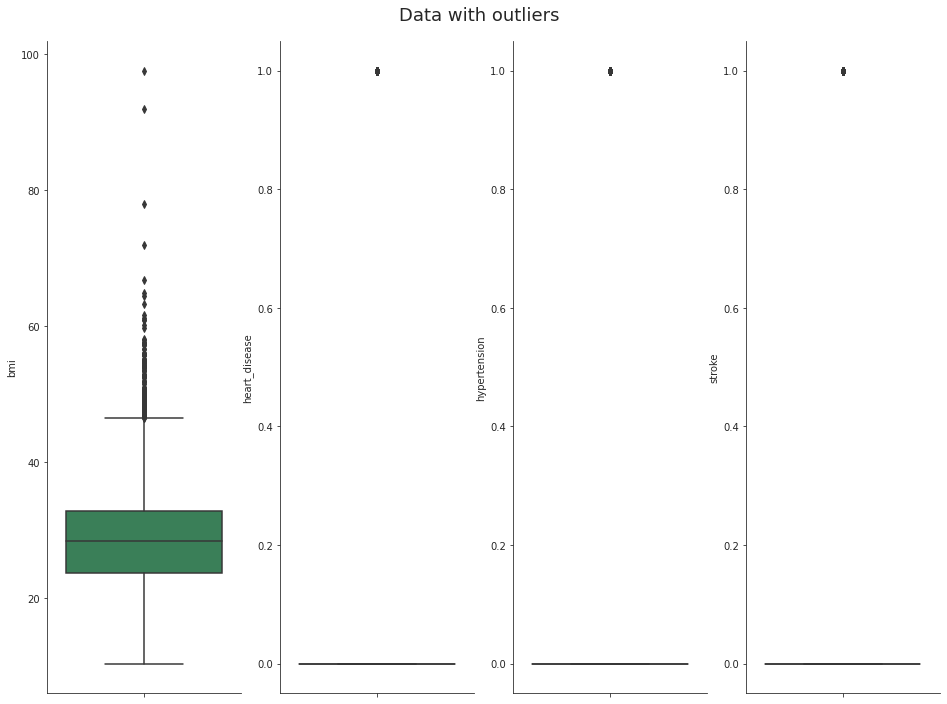

In [ ]:
sns.set_style("ticks")
fig, ax1 = plt.subplots(1, 4, figsize=(16, 12))
plt.rc("font", size=14)

sns.boxplot(y=stroke_eda["bmi"], color="seagreen", ax=ax1[0])
sns.boxplot(y=stroke_eda["heart_disease"], color="seagreen", ax=ax1[1])
sns.boxplot(y=stroke_eda["hypertension"], color="seagreen", ax=ax1[2])
sns.boxplot(y=stroke_eda["stroke"], color="seagreen", ax=ax1[3])

plt.suptitle("Data with outliers", y=0.92, fontsize=18)
sns.despine()
plt.show()



*   There are people with a higher BMI than the average
*   The other three columns contain only the 0 and 1, which were misinterpreted as outliers
*   BMI is not the best indicator for assessing the health of people according to [medicalnewstoday](https://www.medicalnewstoday.com/articles/265215#Waist-to-height-ratio-better-than-BMI) A 6ft-tall Olympic 100 meter sprinter weighing 90kg (200lbs) may have the same BMI (26) as a couch potato of the same height and weight.





# 3 Inferential Statistical Analysis & EDA

## 3.1 Age distribution

In this section, the distributions of the two groups were checked. One group is people who have had a heart stroke, and the second is those who have not had one.

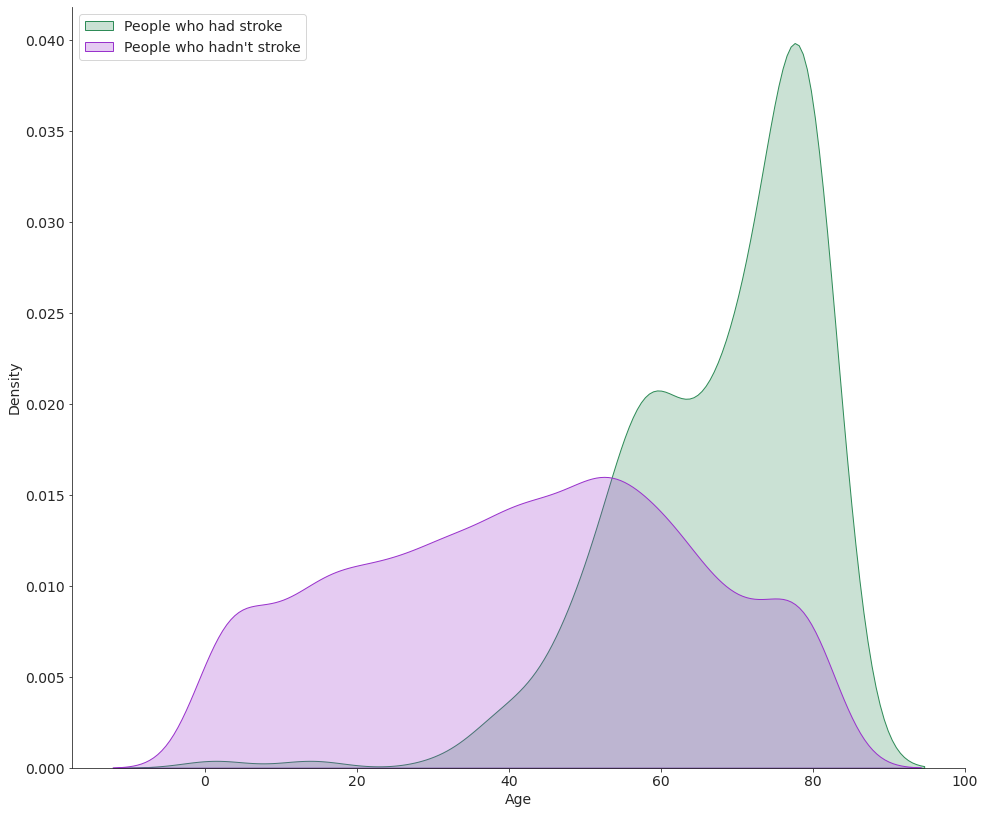

In [ ]:
dist_plot("age", "stroke", "Age", "People who had stroke", "People who hadn't stroke")

Insights:


*   The distribution of the number of people who have suffered a heart stroke is right-skewed and we can observe some outliers in the age group from 15 to 20 years. 
*   The outliers shown above may appear due to a **Blood vessel in the neck**, up to 25 percent of stroke cases in people under the age of 45 are caused by it. According to [everydayhealth](https://www.everydayhealth.com/news/think-youre-too-young-stroke/) it can occur for a number of reasons, including whiplash or  sports-related trauma. Also high blood pressure, high cholesterol, diabetes, and obesity, are becoming more common in younger people.
*  The data of people who have not suffered from a heart attack is distributed more normally.

## 3.2 Difference between male and female

In this section, I will try to check if there is a difference in the number of stroke survivors between the two sexes. First of all, we need to examine how many men and women are contained in the dataset.

### 3.2.1 Number of females and males in a given dataset

In [ ]:
stroke_eda.groupby(["gender"])["gender"].count().rename("total").reset_index()

,gender,total
0,Female,2994
1,Male,2115
2,Other,1


*   There are more females than males in given data set
*   There is also one unknown gender



### 3.2.2 The difference in the number of people who have had a stroke between the two sexes

As we have already found out, there is a difference in the number of women and men in this dataset. I think the best way to determine how different the number of strokes is to show the ratio. **A person who has not had a stroke / A person who has had a stroke**

In [ ]:
ratio = stroke_eda[stroke_eda["stroke"] == 1]

ratio = pd.DataFrame(
    stroke_eda.groupby(["stroke", "gender"]).agg(mean=("stroke", "count"))
).reset_index()

In [ ]:
ratio = pd.DataFrame(
    data={
        "Gender": [ratio.iloc[0, 1], ratio.iloc[1, 1]],
        "Stroke ratio": [
            ratio.iloc[3, 2] / ratio.iloc[0, 2],
            ratio.iloc[4, 2] / ratio.iloc[1, 2],
        ],
    }
)
ratio

,Gender,Stroke ratio
0,Female,0.049422
1,Male,0.053812


From the above results, we can conclude that there is a slight difference between the sexes in the number of heart attacks. This difference could occur due to men are more likely to suffer from alcohol drinking and smoking [cdc.gov](https://www.cdc.gov/stroke/men.htm). 

## 3.3 Urban vs Rural

We already have some information about the genders, now let's try to find out how different lifestyles are in cities and rural areas. People living in rural areas are called healthier because of less air pollution, a large number of green spaces around them, etc.

In [ ]:
living_area = (
    stroke_eda.groupby(["Residence_type", "stroke"])
    .agg(total=("stroke", "count"))
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .sort_values(by=["Residence_type", "stroke"], ascending=[True, False])
    .reset_index()
)

In [ ]:
living_area = living_area[living_area["stroke"] != 0]

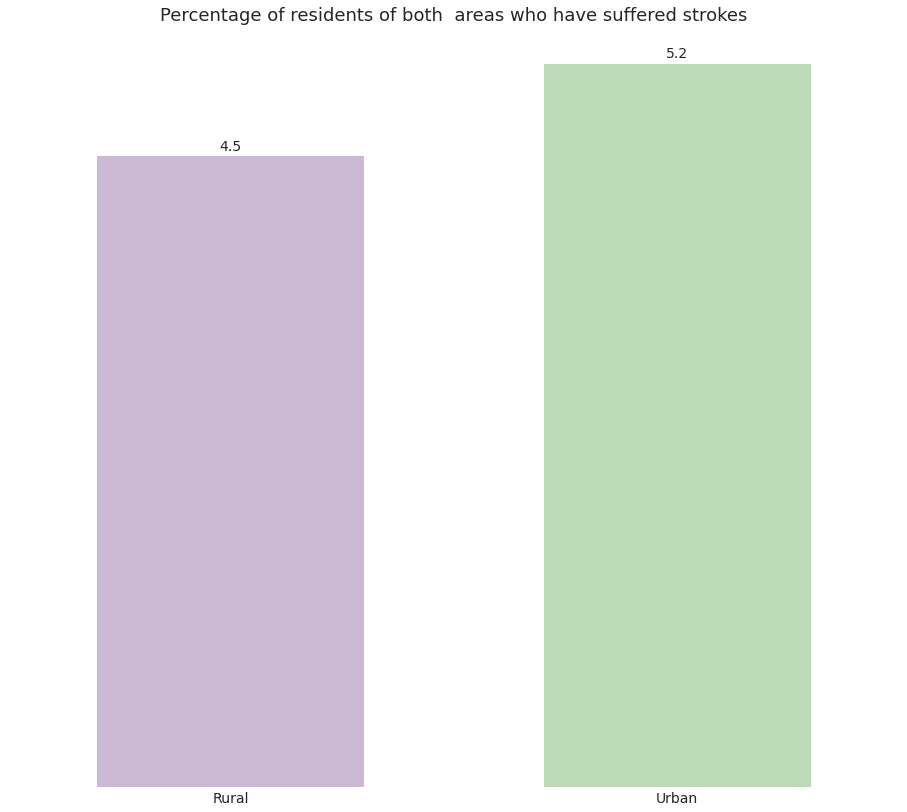

In [ ]:
bar_plot(
    living_area,
    "Residence_type",
    "total",
    "Percentage of residents of both  areas who have suffered strokes",
)

From the graph:

* As expected, a larger percentage of the urban population suffered from a heart attack compared to the rural.
* It may also indicate that rural areas are healthier compared to urban areas.

## 3.4 Glucose level

There are three main groups of glucose levels, and in this section, I will study how the percentage of people who have had a stroke differs between these groups. According to [agamatrix](https://agamatrix.com/blog/normal-blood-sugar-level-chart/) glucose groups are:

**Low blood sugar**
*   51-70 mg/dL - Red flag
*   71-90 mg/dL - Yellow flag

**Normal blood sugar**
*   90-180 mg/dL

**High blood sugar**
**Low blood sugar**
*  180-250 mg/dL - Yellow flag
*   More than 250 mg/dL - Red flag




In [ ]:
glucose_level = stroke_eda.copy()
glucose_level["bins"] = pd.cut(
    x=glucose_level["avg_glucose_level"],
    bins=[50, 70, 90, 180, 250, 300],
    labels=[
        "51-70 mg/dL",
        "71-90 mg/dL",
        "90-180 mg/dL",
        "180-250 mg/dL",
        "more than 250 mg/dL",
    ],
)

In [ ]:
glucose_level = (
    glucose_level.groupby(["bins", "stroke"])
    .agg(total=("stroke", "count"))
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .sort_values(by=["bins", "stroke"], ascending=[True, False])
    .reset_index()
)

In [ ]:
glucose_level = glucose_level[glucose_level["stroke"] != 0]

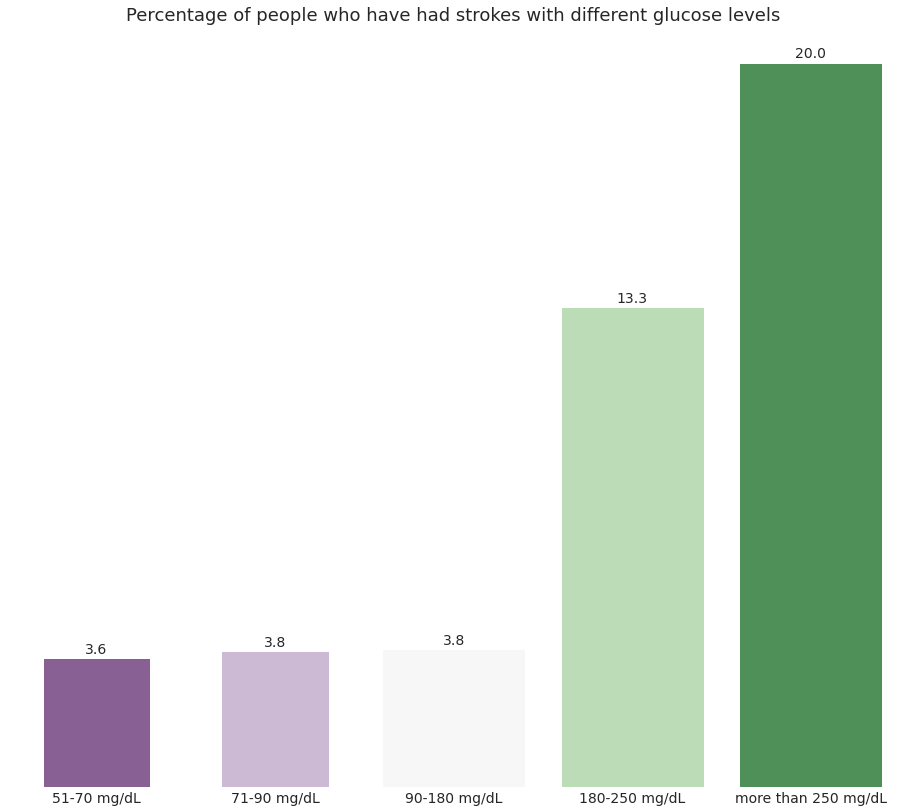

In [ ]:
bar_plot(
    glucose_level,
    "bins",
    "total",
    "Percentage of people who have had strokes with different glucose levels",
)

*   We see that, despite the fact that low glucose levels are harmful to health, the percentage of people who have suffered a heart stroke is the same.
*   We can also assume that higher glucose levels may increase the likelihood of a heart attack.



## 3.5 BMI and marriage status

There is an opinion that after marriage, people gain extra weight due to lack of time and a more passive lifestyle. In this section, this opinion will be studied.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


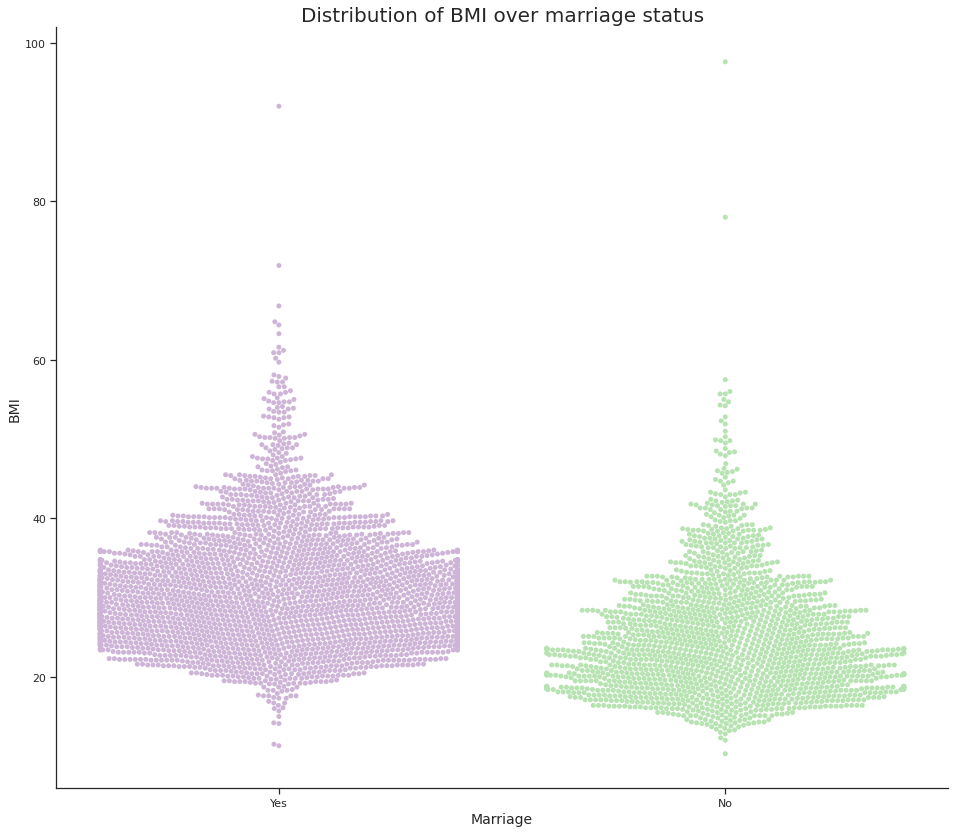

In [ ]:
swarm_plot(
    stroke_eda,
    "ever_married",
    "bmi",
    "Marriage",
    "BMI",
    "Distribution of BMI over marriage status",
)

Insights:
*   We can see that there are more people with a bigger BMI number who have married.
*   The data points representing married people are more densely distributed.



## 3.6 Is there a significant difference between those who got married and those who didn't?

We have already determined that there is a difference in BMI between these two groups, in this part I will check whether it is significant.


$H_0$ - there is no difference in BMI between married and unmarried people.

$H_a$ - Married people have a higher average BMI than the unmarried.

$\alpha = 0.05$

In [ ]:
marriage = pd.DataFrame(
    stroke_eda.groupby(["ever_married"]).agg(
        mean=("bmi", "mean"),
        std=("bmi", "std"),
        sample_size=("ever_married", "count"),
    )
).reset_index()
marriage["mean"] = marriage["mean"].astype("int64")
marriage

,ever_married,mean,std,sample_size
0,No,25,7.721598,1757
1,Yes,30,7.005531,3353


We see that the average BMI is very different. In addition, the sample sizes are very different, so it is necessary to perform a power analysis.

In [ ]:
# differencce of two means
marriage_mean = marriage.iloc[1]["mean"] - marriage.iloc[0]["mean"]
marriage_mean

5

In [ ]:
# estimated standard deviation
marriage__est_std = np.sqrt(
    (marriage.iloc[0]["std"] ** 2 + marriage.iloc[1]["std"] ** 2) / 2
)
marriage__est_std

7.372263372609583

In [ ]:
# effect size
marriage_mean / marriage__est_std

0.6782177666870486

To prevent p-hacking, a preliminary power analysis was carried out. After filling the calculator with the obtained values, the output of the total sample size was equal to 100. In conclusion, there should be no p-hacking.

Sample size calculator: [ai-therapy](https://www.ai-therapy.com/psychology-statistics/sample-size-calculator)

In [ ]:
married_no = stroke_eda[(stroke_eda["ever_married"] == "No")]["bmi"]
married_yes = stroke_eda[(stroke_eda["ever_married"] == "Yes")]["bmi"]

cm = sms.CompareMeans(sms.DescrStatsW(married_yes), sms.DescrStatsW(married_no))
lb, ub = cm.tconfint_diff(usevar="unequal")

print("Confidence Interval with 'sms' is from %0.4f to %0.4f" % (lb, ub))

Confidence Interval with 'sms' is from 5.1595 to 6.0238


The zero value does not fall within the boundaries of the confidence interval, which means that there is a significant difference between the average bmi of people in the two groups.

In [ ]:
stat, p = ttest_ind(married_yes, married_no)

print("Using t-test from Python module:\nt_stat: %0.3f, \np_value: %0.3f" % (stat, p))

Using t-test from Python module:
t_stat: 26.153, 
p_value: 0.000


The P-value is less than 0.05, so we can reject the null hypothesis, which means that there is a significant difference. Despite the fact that BMI is not the most accurate indicator, after marriage, people on average have a higher BMI.

## 3.7 Estimating the population with confidence

In this part, data on heart diseases will be used to determine with 95% confidence the proportion of the population suffering from heart disease. Three different groups of workers will be considered: Goverment jobs, The Private sector and The Self-employed.

In [ ]:
hear_dis = (
    stroke_eda.groupby(["work_type", "heart_disease"])
    .agg(total=("heart_disease", "count"))
    .reset_index()
)
hear_dis = hear_dis[
    (hear_dis.work_type != "children") & (hear_dis.work_type != "Never_worked")
]

In [ ]:
results = []
result_df = pd.DataFrame(
    {"Work Type": ["Govt_job", "Private", "Self-employed"], "Population proportion": ""}
)
a = 0
b = 1
for i in range(3):
    p_hat = (
        (hear_dis.iloc[a]["total"] + hear_dis.iloc[b]["total"])
        / hear_dis.iloc[b]["total"]
    ) / 100
    n = hear_dis.iloc[a]["total"] + hear_dis.iloc[b]["total"]
    result_df.loc[i, ["Population proportion"]] = [sms.proportion_confint(n * p_hat, n)]
    a, b = a + 2, b + 2
result_df

,Work Type,Population proportion
0,Govt_job,"(0.15296474523783554, 0.21203525476216445)"
1,Private,"(0.17105105661602713, 0.19920210794093493)"
2,Self-employed,"(0.08046403362370066, 0.12175818859852156)"


From the table:
*   The proportion of people working in the public and private sectors suffering from heart disease among the population was the same.
*   Their much smaller percentage of self-employed people who have had heart diseases. This may indicate that this type of work is less stressful compared to the other two. 



## 3.8 Smoking types and stroke

The purpose of this section is to check how different the number of people who have suffered a stroke is in different groups of smokers. I believe that smoking can negatively affect health and especially increase the likelihood of stroke.

In [ ]:
smoking_df = (
    stroke_eda.groupby(["stroke", "smoking_status"])
    .agg(total=("smoking_status", "count"))
    .reset_index()
)

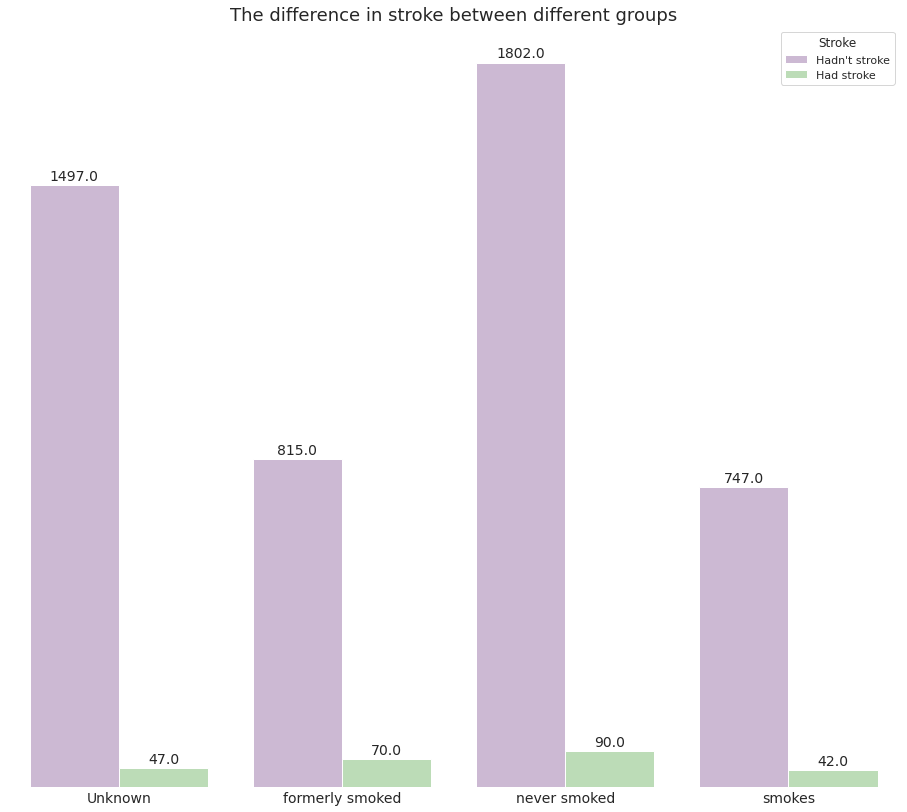

In [ ]:
bar_plot2(
    smoking_df,
    "smoking_status",
    "total",
    "The difference in stroke between different groups",
    "stroke",
    ["Hadn't stroke", "Had stroke"],
    "Stroke",
)

From the plot:

*  We can conclude that smokers have more cases of heart stroke compared to non-smokers.
* In addition, the ratio between former smokers is slightly higher compared to smokers.

## 3.9 Distribution of hypertension

We have already checked the age distribution of two groups who had a stroke and who did not have one. In this part, we will check how the age differs between the two groups who had hypertension and those who did not have it.

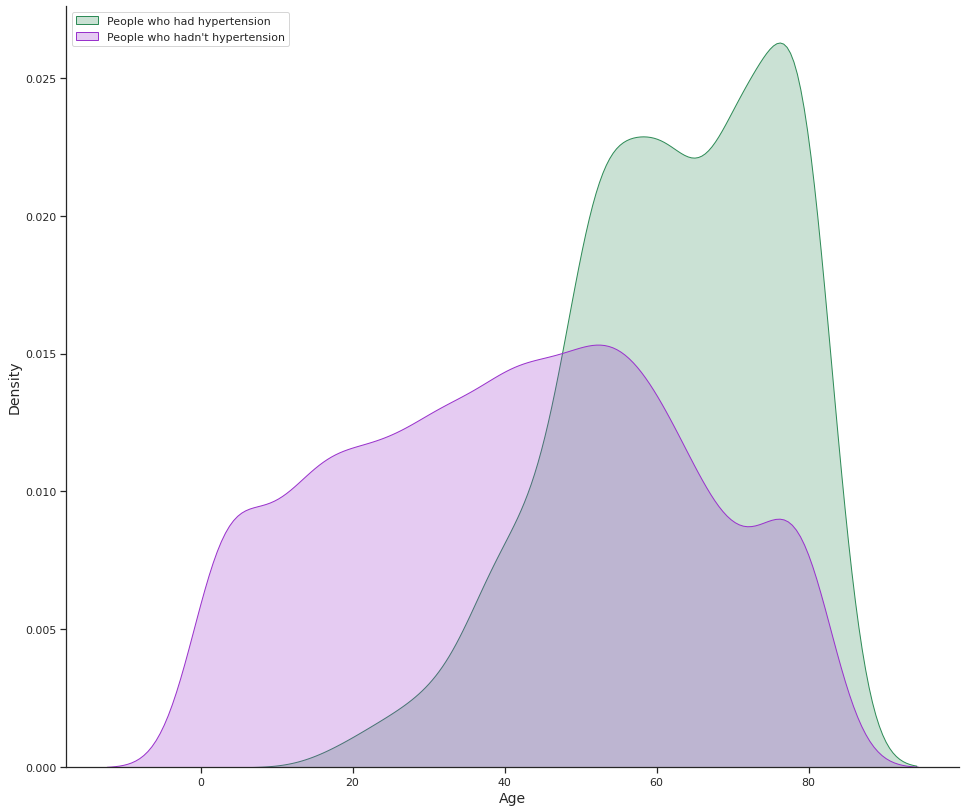

In [ ]:
dist_plot(
    "age",
    "hypertension",
    "Age",
    "People who had hypertension",
    "People who hadn't hypertension",
)

Insights:

* Same as before hypertension is more relevant for older people, while age distribution of those who hadn't hypertension is more normal. 

## 3.10 Correlation between features

In this part, I will study the correlation between different features.


In [ ]:
stroke_eda["ever_married"].replace(["No", "Yes"], [0, 1], inplace=True)
stroke_eda["Residence_type"].replace(["Urban", "Rural"], [0, 1], inplace=True)
stroke_eda["gender"].replace(["Female", "Male"], [0, 1], inplace=True)

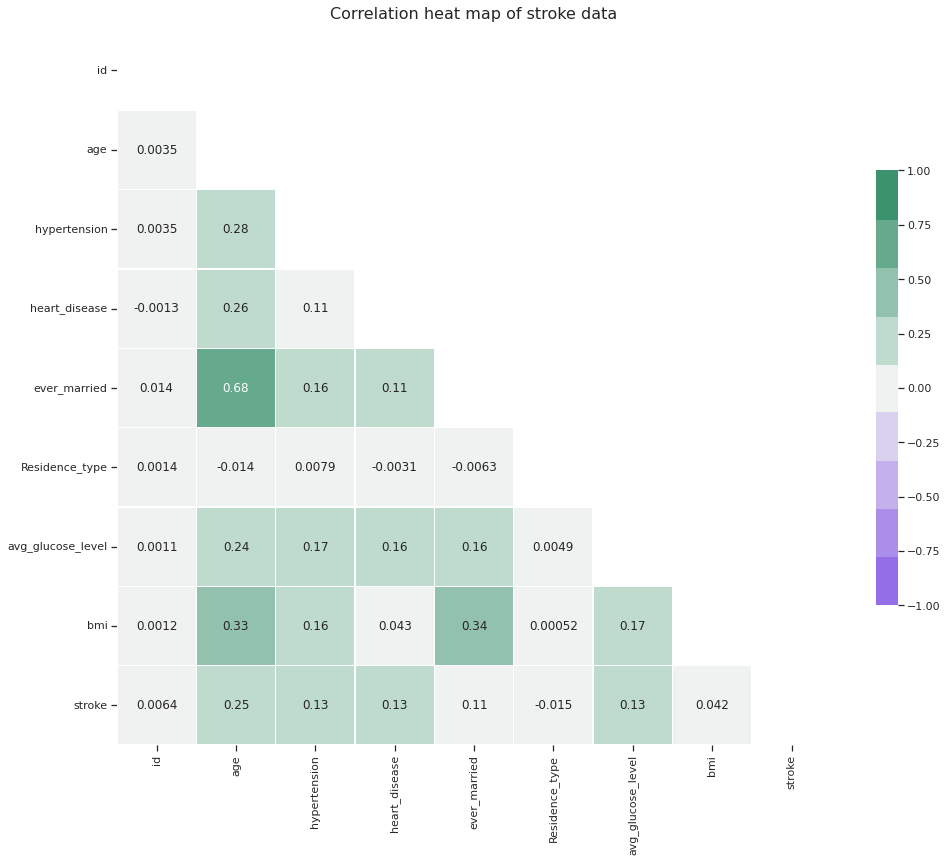

In [ ]:
corr = stroke_eda.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(275, 150, s=80, l=55, n=9)
heatmap = sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

heatmap.set_title(
    "Correlation heat map of stroke data",
    fontdict={"fontsize": 16},
    pad=12,
)
plt.xlabel("")
plt.ylabel("");

From given chart we can see that almost all features have positive correlation and the strongest correlation is between marriage status and age. In addition, all other characteristics have the strongest correlation with age, with the exception of BMI, which has a strong correlation with marriage status.

# 4 Predictions

### 4.1 Stroke prediction

The purpose of this segment is to predict whether a person will have a stroke or not.

#### 4.1.1 Baseline Model

In this part, I will cross-validate  four selected models and, according to the results, select several models for further  hyperparameters tuning.

In [ ]:
stroke_df["bmi"] = stroke_df["bmi"].fillna(
    stroke_df.groupby("age")["bmi"].transform("mean")
)

In [ ]:
stroke_df = stroke_df.drop("id", 1)

In [ ]:
X = stroke_df.drop(columns=["stroke"])
y = stroke_df["stroke"]

In [ ]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

In [ ]:
numeric_features = ["age", "avg_glucose_level", "bmi"]
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"))
base_df = base_line(X, y)

In [ ]:
base_df

,Accuracy,Recall,Precision,f1,Roc Auc
XGB classifier,0.823875,0.678788,0.557154,0.562121,0.805326
Random Forest,0.906262,0.560143,0.549787,0.553857,0.779814
Cat Boost,0.918004,0.549239,0.555606,0.551748,0.770621
LGBM classifier,0.911546,0.540155,0.538104,0.538349,0.789674


Due to the highly unbalanced classes, SMOTE and Tomek Links were used. Despite the low accuracy, XGB shows the best results in all other indicators. In this particular case, the decision was based on Roc values, and for future hyperparameter tuning, Random Forest, XGB and LGBM classifiers were selected.

#### 4.1.2 Hyper parameter tuning

Now I will continue working with previously selected models and I will perform hyperparameter tuning to achieve even better results.

In [ ]:
counter = collections.Counter(y)
estimate = counter[0] / counter[1]
print("Estimate: %.3f" % estimate)

Estimate: 19.522


Since we have an unbalanced dataset and SMOTE is inefficient with "boosted" models, **scale_pos_weight** will be used. However for LGBM, could not find a decent value, and for this situation I found it manually.

##### 4.1.2 LGBM

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=42
)

In [ ]:
lgbm_stroke = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LGBMClassifier(**lgbm_params, scale_pos_weight=19.522)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, lgbm_stroke.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       480
           1       0.16      0.81      0.27        31

    accuracy                           0.73       511
   macro avg       0.57      0.77      0.55       511
weighted avg       0.93      0.73      0.80       511



From the above results, we can see that due to highly imbalanced data, the results for class 1 are slightly worse, except recall. The f1 score targeted metric has the best result compared to other models.

In [ ]:
filename = "lgbm_stroke_model.sav"
pickle.dump(lgbm_stroke, open(filename, "wb"))

##### 4.1.2 XGB

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBM Classifier")
func = lambda trial: xgboost_objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
xgb_params = trial.params

In [ ]:
xgb_stroke = ImPipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier(**xgbm_params))]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, xgb_stroke.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78       480
           1       0.14      0.87      0.24        31

    accuracy                           0.66       511
   macro avg       0.56      0.76      0.51       511
weighted avg       0.94      0.66      0.75       511



From the given metrics, we can conclude that XGB performed worse compared to other models.



##### 4.1.2 Random forest

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Forest Classifier")
func = lambda trial: forest_objective(trial, X, y)
study.optimize(func, n_trials=10)

In [ ]:
trial = study.best_trial
tree_params = trial.params

In [ ]:
forest_stroke = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", RandomForestClassifier(**tree_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, forest_stroke.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       480
           1       0.14      0.26      0.18        31

    accuracy                           0.86       511
   macro avg       0.54      0.58      0.55       511
weighted avg       0.90      0.86      0.88       511



Random forest has the best accuracy and f1 score for class 0, however, it has a terrible f1 score for class 1

#### 4.1.3 Confusion Matrix

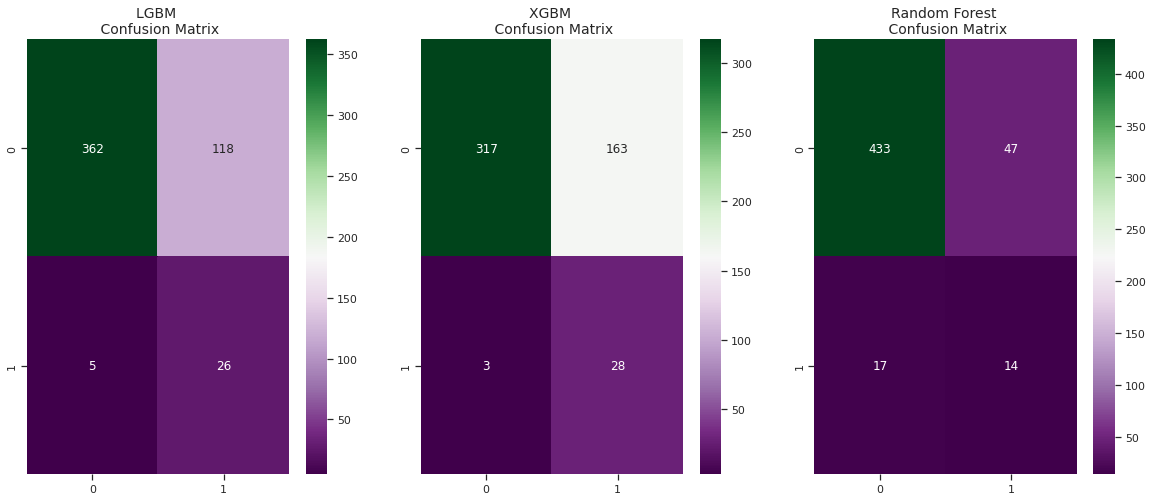

In [ ]:
call_conf_matrix(lgbm_stroke, xgbm_stroke, forest_stroke)

From the given confusion matrices, we can see that the best true negative prediction is made by a random forest. However, the prediction of a true positive result is worse compared to other models. The best true positive result was obtained by XGB. LGBM is more balanced compared to other models.

#### 4.1.4 ROC AUC

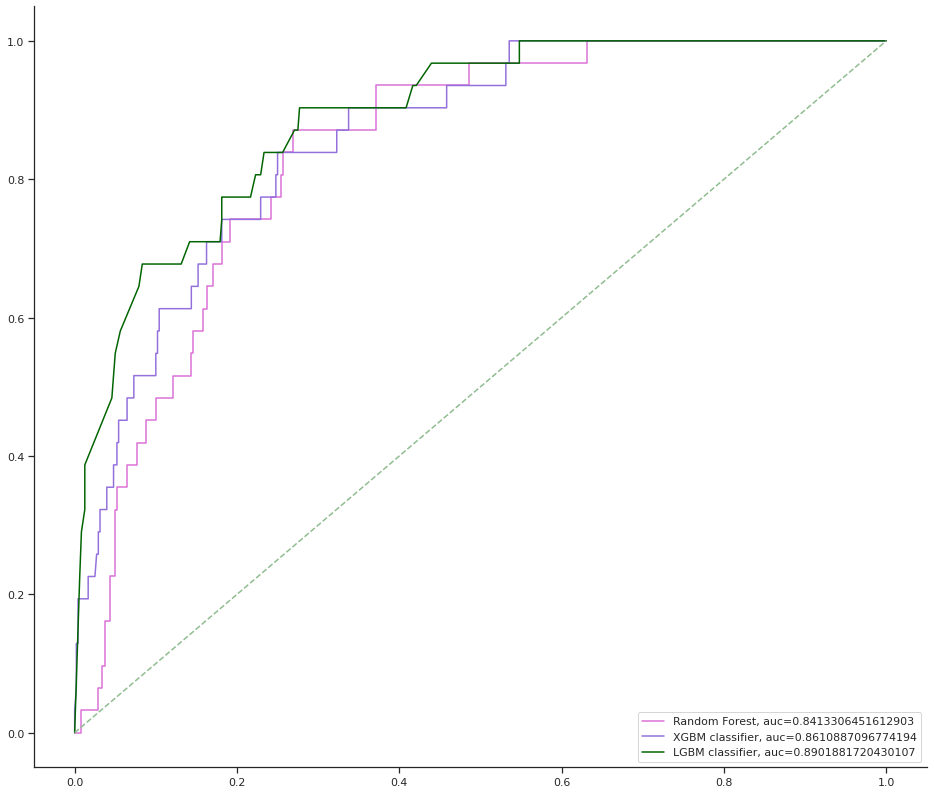

In [ ]:
y_pred_tree = forest_stroke.predict_proba(X_test)[::, 1]
tree_fpr, tree_tpr, tree_ = metrics.roc_curve(y_test, y_pred_tree)
auc_tree = metrics.roc_auc_score(y_test, y_pred_tree)

y_pred_xgbm = xgbm_stroke.predict_proba(X_test)[::, 1]
xgbm_fpr, xgbm_tpr, xgbm_ = metrics.roc_curve(y_test, y_pred_xgbm)
auc_xgbm = metrics.roc_auc_score(y_test, y_pred_xgbm)

y_pred_lgbm = lgbm_stroke.predict_proba(X_test)[::, 1]
lgbm_fpr, lgbm_tpr, lgbm_ = metrics.roc_curve(y_test, y_pred_lgbm)
auc_lgbm = metrics.roc_auc_score(y_test, y_pred_lgbm)

sns.set_style("ticks")
plt.figure(figsize=(16, 14))
plt.plot(
    tree_fpr, tree_tpr, color="orchid", label="Random Forest, auc=" + str(auc_tree)
)
plt.plot(
    xgbm_fpr,
    xgbm_tpr,
    color="mediumpurple",
    label="XGBM classifier, auc=" + str(auc_xgbm),
)
plt.plot(
    lgbm_fpr, lgbm_tpr, color="darkgreen", label="LGBM classifier, auc=" + str(auc_lgbm)
)
plt.plot([0, 1], [0, 1], color="darkseagreen", linestyle="--", label="")
plt.legend(loc=4)
sns.despine()
plt.show()

*   Best ROC AUC value was achvieved by LGBM classifier
*   According to all previous results and metrics we can assume that LGBM classifier did the best work and I will explore it more deeply.



#### 4.1.5 Shap values of LGBM

In this part, I will plot two shap graphs  to understand which features had the greatest impact on the decision.

In [ ]:
stroke_cat_all = feature_names(lgbm_stroke)

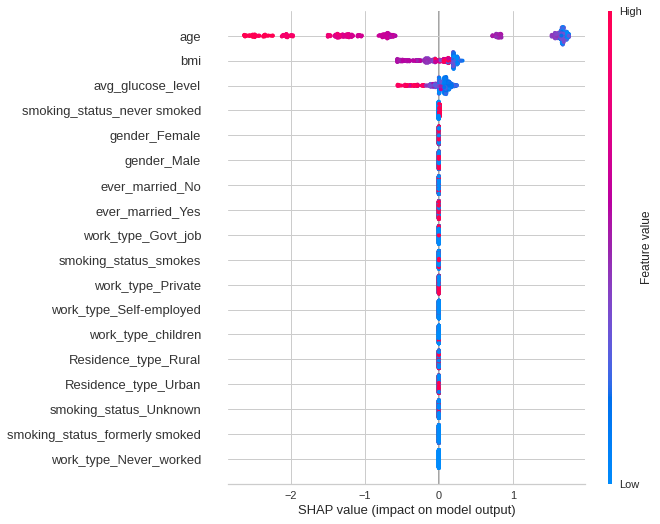

In [ ]:
lgbm_explainer = shap.TreeExplainer(lgbm_stroke["classifier"])
lgbm_shap_values = lgbm_explainer(preprocessor.transform(X_test))
shap.summary_plot(lgbm_shap_values[:, :, 0], feature_names=stroke_cat_all)

*   The most interesting observation is that basically there were only three main features that influenced the outcome of the forecast.
*   Biggest impact of all features had age

**NOTE**: this results may not indicate real performance as shap valuse doesn't work great with LGBM model.




In [ ]:
shap.initjs()
shap.plots.force(lgbm_shap_values[:, :, 0][0], feature_names=stroke_cat_all)

*   Most important foundig that force plot indicates that on average possibility to don't geat stroke is 1.26. This value doesnt corespond to true, real average probability is around 0.82.
*   We can see that age is pushing mostly towards not getting stroke. IIt is followed by BMI, which means that body shape has a big impact, despite the fact that this is not the most accurate metric.



### 4.2 Hypertension prediction

#### 4.2.1 Baseline Model

In this part, I will cross-validate four selected models and, according to the results, select several models for further hyperparameters tuning.

In [ ]:
X = stroke_df.drop(columns=["hypertension"])
y = stroke_df["hypertension"]

In [ ]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

In [ ]:
numeric_features = ["age", "avg_glucose_level", "bmi"]
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"))
base_df = base_line(X, y)

In [ ]:
base_df

,Accuracy,Recall,Precision,f1,Roc Auc
XGB classifier,0.733659,0.681456,0.578912,0.573367,0.782901
Random Forest,0.839530,0.589650,0.577054,0.581580,0.763574
Cat Boost,0.844618,0.587089,0.580606,0.581920,0.760261
LGBM classifier,0.850489,0.580430,0.581188,0.579445,0.768136


We can conclude that the results are very similar to stroke prediction, and exactly the same models showed the best results. Therefore, I will choose three models for further investigation.

#### 4.2.2 Hyper parameter tuning

Now I will continue working with previously selected models and I will perform hyperparameter tuning to achieve even better results.

In [ ]:
counter = collections.Counter(y)
estimate = counter[0] / counter[1]
print("Estimate: %.3f" % estimate)

Estimate: 9.261


##### 4.2.2 LGBM

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=42
)

In [ ]:
lgbm_hypertension = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LGBMClassifier(**lgbm_params, scale_pos_weight=9.261)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, lgbm_hypertension.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.96      0.61      0.75       460
           1       0.18      0.76      0.29        51

    accuracy                           0.63       511
   macro avg       0.57      0.69      0.52       511
weighted avg       0.88      0.63      0.70       511



In [ ]:
filename = "lgbm_hypertension_model.sav"
pickle.dump(lgbm_hypertension, open(filename, "wb"))

##### 4.2.2 XGB

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBM Classifier")
func = lambda trial: xgboost_objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
xgbm_params = trial.params

In [ ]:
xgbm_hypertension = ImPipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier(**xgbm_params))]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, xgbm_hypertension.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79       460
           1       0.19      0.67      0.29        51

    accuracy                           0.68       511
   macro avg       0.57      0.67      0.54       511
weighted avg       0.87      0.68      0.74       511



##### 4.2.2 Random forest

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Forest Classifier")
func = lambda trial: forest_objective(trial, X, y)
study.optimize(func, n_trials=10)

In [ ]:
trial = study.best_trial
tree_params = trial.params

In [ ]:
forest_hypertension = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", RandomForestClassifier(**tree_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_valid, forest_hypertension.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76       460
           1       0.19      0.78      0.31        51

    accuracy                           0.65       511
   macro avg       0.58      0.71      0.53       511
weighted avg       0.89      0.65      0.72       511



*   We can conclude that the best f1 result for 0 has XGB and for 1 random forest
*   Like last time, LGBM is the golden mean.
*   Best accuracy have XGB model





#### 4.2.3 Confusion Matrix

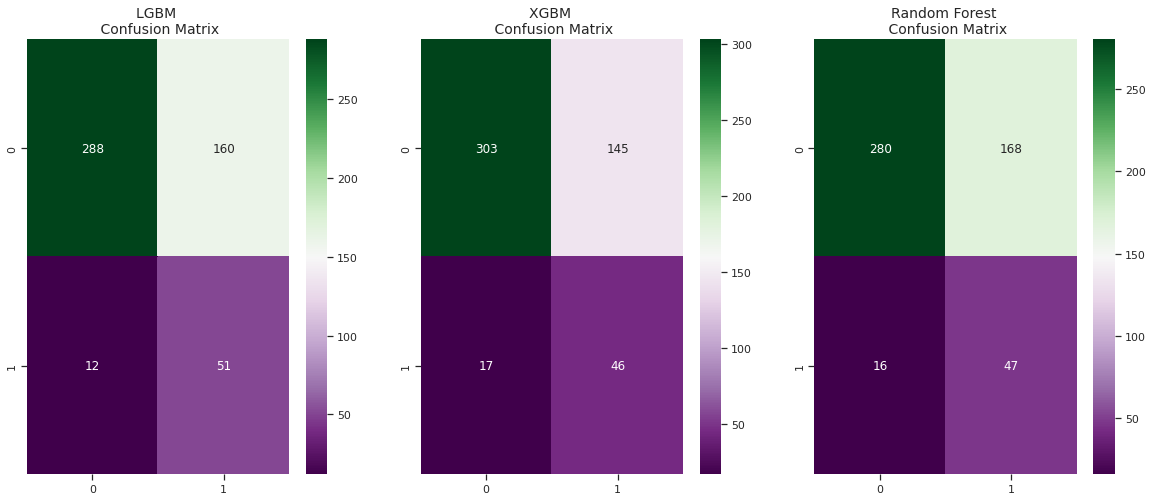

In [ ]:
call_conf_matrix(lgbm_hypertension, xgbm_hypertension, forest_hypertension)

From the Confusion matrices:

*   As for the fact that it is most important for us to correctly predict a stroke, the LGBM model coped best, since it has the least number of false positive results and the largest number of true positive ones.




#### 4.2.4 ROC AUC

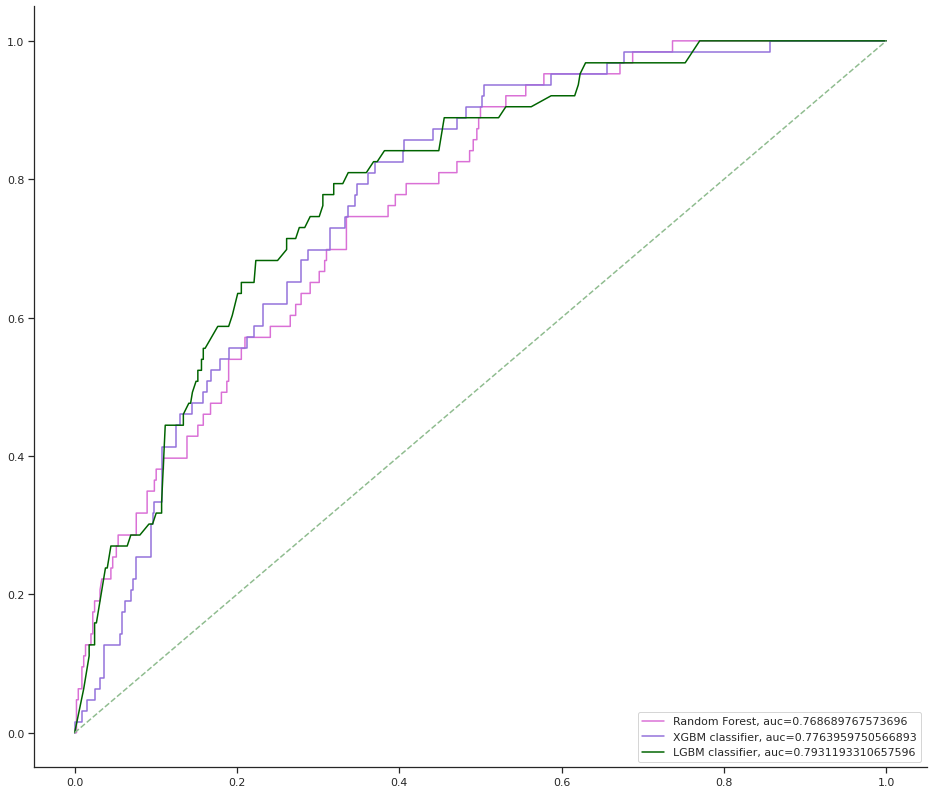

In [ ]:
y_pred_tree = forest_hypertension.predict_proba(X_test)[::, 1]
tree_fpr, tree_tpr, tree_ = metrics.roc_curve(y_test, y_pred_tree)
auc_tree = metrics.roc_auc_score(y_test, y_pred_tree)

y_pred_xgbm = xgbm_hypertension.predict_proba(X_test)[::, 1]
xgbm_fpr, xgbm_tpr, xgbm_ = metrics.roc_curve(y_test, y_pred_xgbm)
auc_xgbm = metrics.roc_auc_score(y_test, y_pred_xgbm)

y_pred_lgbm = lgbm_hypertension.predict_proba(X_test)[::, 1]
lgbm_fpr, lgbm_tpr, lgbm_ = metrics.roc_curve(y_test, y_pred_lgbm)
auc_lgbm = metrics.roc_auc_score(y_test, y_pred_lgbm)

sns.set_style("ticks")
plt.figure(figsize=(16, 14))
plt.plot(
    tree_fpr, tree_tpr, color="orchid", label="Random Forest, auc=" + str(auc_tree)
)
plt.plot(
    xgbm_fpr,
    xgbm_tpr,
    color="mediumpurple",
    label="XGBM classifier, auc=" + str(auc_xgbm),
)
plt.plot(
    lgbm_fpr, lgbm_tpr, color="darkgreen", label="LGBM classifier, auc=" + str(auc_lgbm)
)
plt.plot([0, 1], [0, 1], color="darkseagreen", linestyle="--", label="")
plt.legend(loc=4)
sns.despine()
plt.show()

* Again best auc score was demonstrated by LGBM. 

So next I will continue to explore LGBM model more deeply

#### 4.2.5 Shap values of LGBM

In this part, I will plot two shap graphs  to understand which features had the greatest impact on the decision.

In [ ]:
hyper_cat_all = feature_names(lgbm_hypertension)

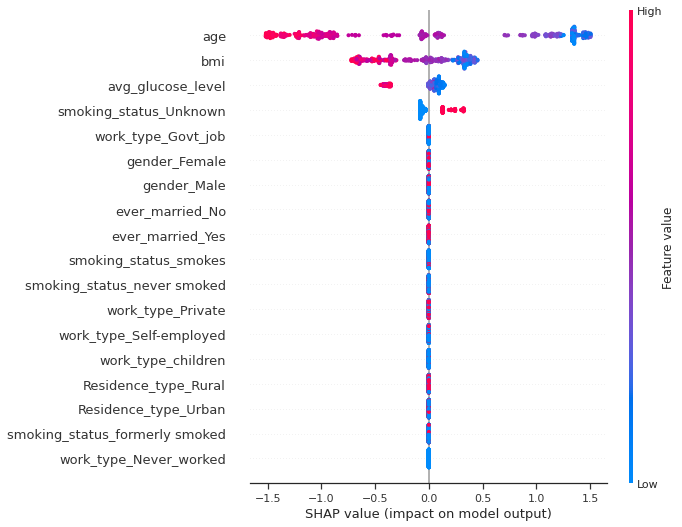

In [ ]:
lgbm_explainer = shap.TreeExplainer(lgbm_hypertension["classifier"])
lgbm_shap_values = lgbm_explainer(preprocessor.transform(X_test))
shap.summary_plot(lgbm_shap_values[:, :, 0], feature_names=hyper_cat_all)

Insights:

*   We see that age is still the most important feature
*   This time there are more features that have a greater impact on the result
*   In addition, we can conclude that it would be possible to carry out more in-depth feature engineering
*   The most interesting observation is that the unknown smoking status has such an impact on the prognosis.



In [ ]:
shap.initjs()
shap.plots.force(lgbm_shap_values[:, :, 0][0], feature_names=hyper_cat_all)


*   Compared to stroke model this time bmi have bigger impact on the outcome
*   Age still pushes mostly towards 0



### 4.3 Average glucose level prediction


#### 4.3.1 Hyper parameter tuning

Since the cross-validation didn't give many different results compared to the previous ones, I skipped it and immediately started working on hyperparameter tuning.

In [ ]:
pred_glucose_level = stroke_df.copy()
pred_glucose_level["glucose_level"] = pd.cut(
    x=pred_glucose_level["avg_glucose_level"],
    bins=[50, 70, 90, 180, 250, 300],
    labels=[
        "51-70 mg/dL",
        "71-90 mg/dL",
        "90-180 mg/dL",
        "180-250 mg/dL",
        "more than 250 mg/dL",
    ],
)
pred_glucose_level = pred_glucose_level.drop("avg_glucose_level", 1)

In [ ]:
X = pred_glucose_level.drop(columns=["glucose_level"])
y = pred_glucose_level["glucose_level"]

In [ ]:
numeric_features = ["age", "bmi"]
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

##### 4.3.1 LGBM

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective_multi(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
lgbm_glucose = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", LGBMClassifier(**lgbm_params)),
    ]
).fit(X_train, y_train)

Despite the fact that using synthetic samples with reinforced models is not the best solution, in this case SMOTE helped to achieve the best results.

In [ ]:
print(classification_report(y_test, lgbm_glucose.predict(X_test)))

                     precision    recall  f1-score   support

      180-250 mg/dL       0.24      0.65      0.36       171
        51-70 mg/dL       0.15      0.20      0.17       210
        71-90 mg/dL       0.37      0.32      0.35       492
       90-180 mg/dL       0.46      0.27      0.34       649
more than 250 mg/dL       0.50      0.09      0.15        11

           accuracy                           0.32      1533
          macro avg       0.35      0.31      0.27      1533
       weighted avg       0.37      0.32      0.32      1533



In [ ]:
filename = "lgbm_glucose_model.sav"
pickle.dump(lgbm_hypertension, open(filename, "wb"))

##### 4.3.1 XGB

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBM Classifier")
func = lambda trial: xgboost_objective_multi(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
xgbm_params = trial.params

In [ ]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

In [ ]:
xgb_glucose = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(**xgbm_params, sample_weights=sample_weights)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, xgb_glucose.predict(X_test)))

                     precision    recall  f1-score   support

      180-250 mg/dL       0.26      0.21      0.23       171
        51-70 mg/dL       0.12      0.08      0.09       210
        71-90 mg/dL       0.31      0.32      0.31       492
       90-180 mg/dL       0.41      0.49      0.45       649
more than 250 mg/dL       0.00      0.00      0.00        11

           accuracy                           0.34      1533
          macro avg       0.22      0.22      0.22      1533
       weighted avg       0.32      0.34      0.33      1533



##### 4.3.1 Random forest

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Forest Classifier")
func = lambda trial: forest_objective_multi(trial, X, y)
study.optimize(func, n_trials=10)

In [ ]:
trial = study.best_trial
tree_params = trial.params

In [ ]:
forest_glucose = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", RandomForestClassifier(**tree_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, forest_glucose.predict(X_test)))

                     precision    recall  f1-score   support

      180-250 mg/dL       0.28      0.57      0.37       171
        51-70 mg/dL       0.13      0.20      0.16       210
        71-90 mg/dL       0.31      0.27      0.29       492
       90-180 mg/dL       0.43      0.29      0.35       649
more than 250 mg/dL       0.00      0.00      0.00        11

           accuracy                           0.30      1533
          macro avg       0.23      0.27      0.23      1533
       weighted avg       0.33      0.30      0.30      1533





*   Best f1 score had LGBM model as its only one had value for "mor than 250 mg/L" class
*   XGB demonstrated the best accuracy



#### 4.3.2 Confusion Matrix

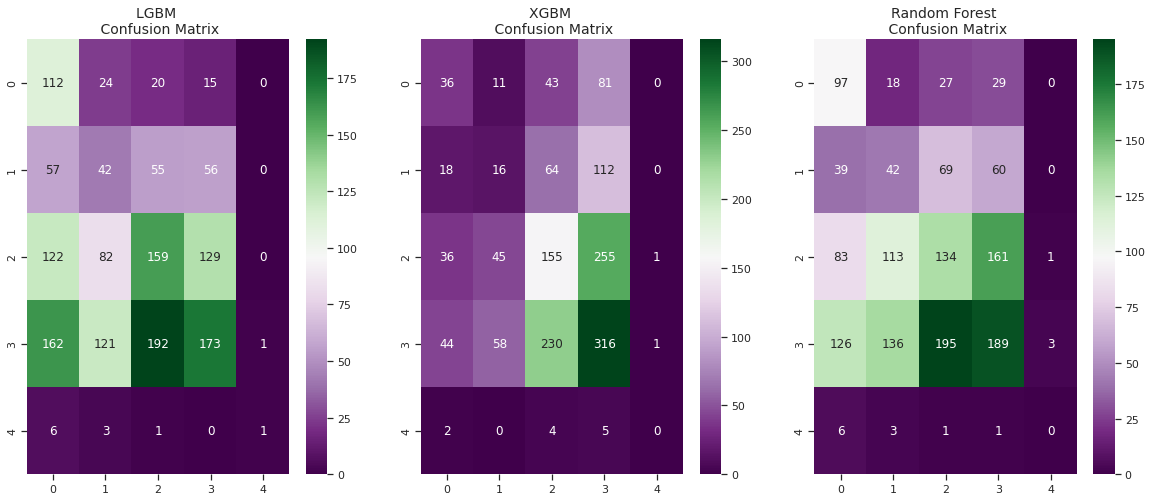

In [ ]:
call_conf_matrix(lgbm_glucose, xgb_glucose, forest_glucose)

Confusion matrices confirms my previous foundigs that LGBM did the best work. Only with class for XGB preformed better.

#### 4.3.3 ROC AUC

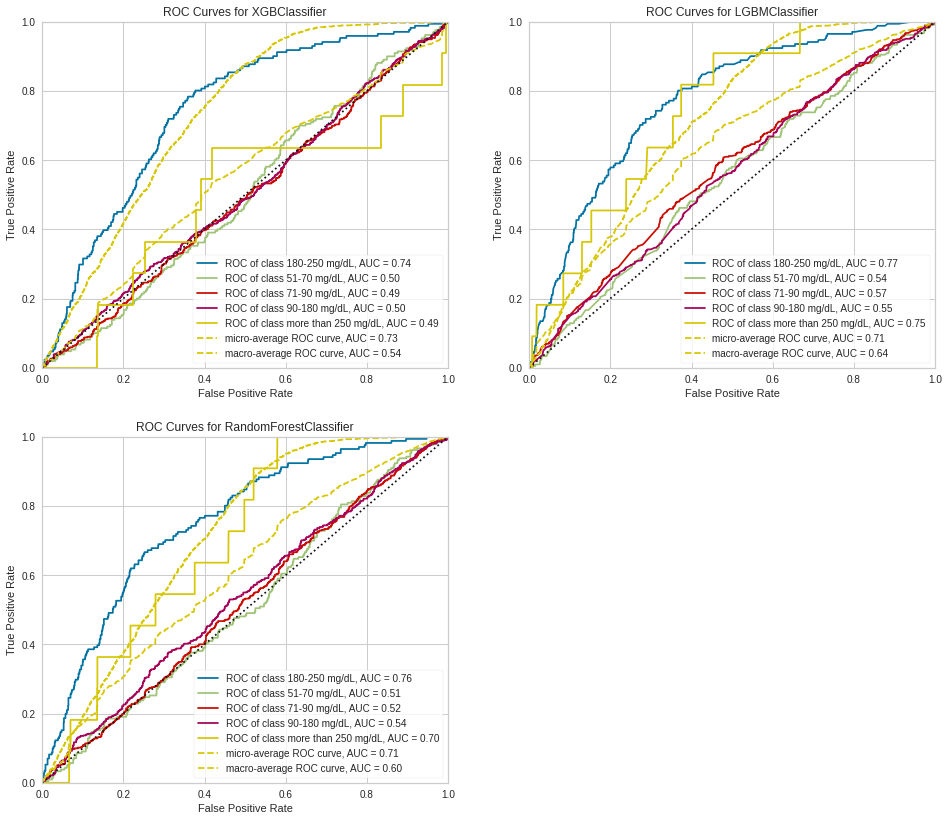

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))


visualgrid = [
    ROCAUC(
        xgb_glucose,
        classes=[
            "180-250 mg/dL",
            "51-70 mg/dL",
            "71-90 mg/dL",
            "90-180 mg/dL",
            "more than 250 mg/dL",
        ],
        ax=axes[0][0],
    ),
    ROCAUC(
        lgbm_glucose,
        classes=[
            "180-250 mg/dL",
            "51-70 mg/dL",
            "71-90 mg/dL",
            "90-180 mg/dL",
            "more than 250 mg/dL",
        ],
        ax=axes[0][1],
    ),
    ROCAUC(
        forest_glucose,
        classes=[
            "180-250 mg/dL",
            "51-70 mg/dL",
            "71-90 mg/dL",
            "90-180 mg/dL",
            "more than 250 mg/dL",
        ],
        ax=axes[1][0],
    ),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
axes[-1, -1].axis("off")
plt.show()

From chart:

*   On average, the results of the LGBM model are better compared to other models




### 4.4 BMI prediction

#### 4.4.1 Hyper parameter tuning


In [ ]:
pred_bmi = stroke_df.copy()
pred_bmi["BMI"] = pd.cut(
    x=pred_bmi["bmi"],
    bins=[10, 18.5, 25, 30, 35, 98],
    labels=[
        "< 18.5 underweight",
        "18.5-25 normal",
        "25-30 overweight",
        "30-35 obese",
        "35< extremly obese",
    ],
)
pred_bmi = pred_bmi.drop("bmi", 1)

In [ ]:
X = pred_bmi.drop(columns=["BMI"])
y = pred_bmi["BMI"]

In [ ]:
numeric_features = ["age", "avg_glucose_level"]
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

##### 4.4.1 LGBM

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: LGBM_objective_multi(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
lgbm_params = trial.params

In [ ]:
lgbm_bmi = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", LGBMClassifier(**lgbm_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, lgbm_bmi.predict(X_test)))

                    precision    recall  f1-score   support

    18.5-25 normal       0.51      0.12      0.19       343
  25-30 overweight       0.26      0.08      0.12       432
       30-35 obese       0.27      0.30      0.28       343
35< extremly obese       0.25      0.66      0.36       282
< 18.5 underweight       0.54      0.85      0.66       133

          accuracy                           0.31      1533
         macro avg       0.37      0.40      0.32      1533
      weighted avg       0.34      0.31      0.26      1533



##### 4.4.1 XGB

In [ ]:
study = optuna.create_study(direction="minimize", study_name="XGBM Classifier")
func = lambda trial: xgboost_objective_multi(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
trial = study.best_trial
xgbm_params = trial.params

In [ ]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

In [ ]:
xgb_bmi = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(**xgbm_params, sample_weights=sample_weights)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, xgb_bmi.predict(X_test)))

                    precision    recall  f1-score   support

    18.5-25 normal       0.32      0.37      0.35       343
  25-30 overweight       0.35      0.40      0.38       432
       30-35 obese       0.25      0.22      0.23       343
35< extremly obese       0.25      0.22      0.23       282
< 18.5 underweight       0.66      0.46      0.54       133

          accuracy                           0.33      1533
         macro avg       0.37      0.33      0.35      1533
      weighted avg       0.33      0.33      0.33      1533



##### 4.4.1 Random forest

In [ ]:
study = optuna.create_study(direction="minimize", study_name="Forest Classifier")
func = lambda trial: forest_objective_multi(trial, X, y)
study.optimize(func, n_trials=10)

In [ ]:
trial = study.best_trial
tree_params = trial.params

In [ ]:
forest_bmi = ImPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resample", resample),
        ("classifier", RandomForestClassifier(**tree_params)),
    ]
).fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, forest_bmi.predict(X_test)))

                    precision    recall  f1-score   support

    18.5-25 normal       0.46      0.19      0.27       343
  25-30 overweight       0.38      0.31      0.34       432
       30-35 obese       0.29      0.33      0.31       343
35< extremly obese       0.26      0.42      0.33       282
< 18.5 underweight       0.57      0.81      0.67       133

          accuracy                           0.35      1533
         macro avg       0.39      0.41      0.38      1533
      weighted avg       0.37      0.35      0.34      1533



In [ ]:
filename = "forest_bmi_model.sav"
pickle.dump(forest_bmi, open(filename, "wb"))

* From obtained results we can conclude that best f1 score was achieved by
Random forest model
* In addition best accuracy have Random forest

#### 4.4.2 Confusion Matrix

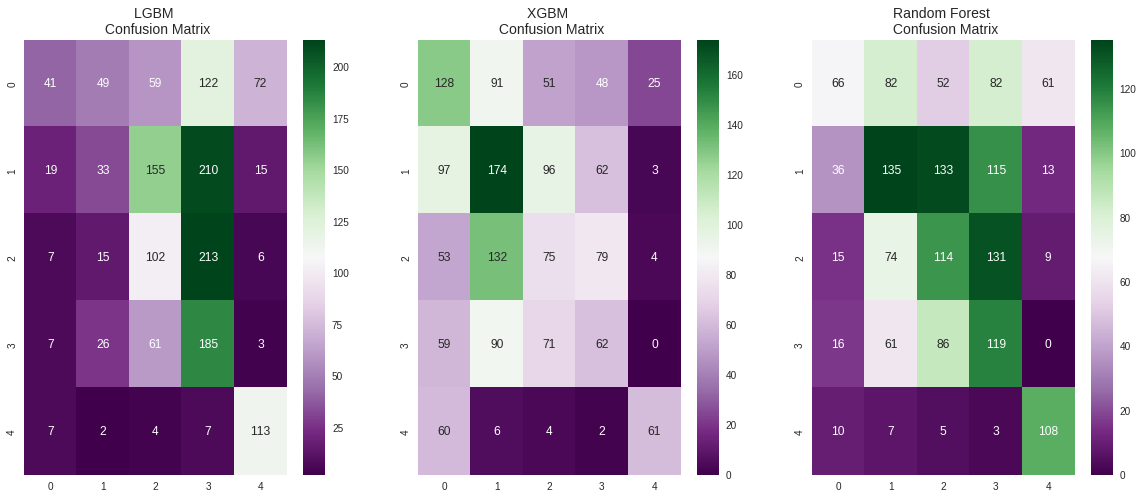

In [ ]:
call_conf_matrix(lgbm_bmi, xgb_bmi, forest_bmi)



*   Compared to glucose prediction, we see that the prediction accuracy is much better, and all models managed to predict a true positive result for the fourth class
*   As it was already determined Random forest did a best job compared to others



##### 4.4.3 ROC AUC

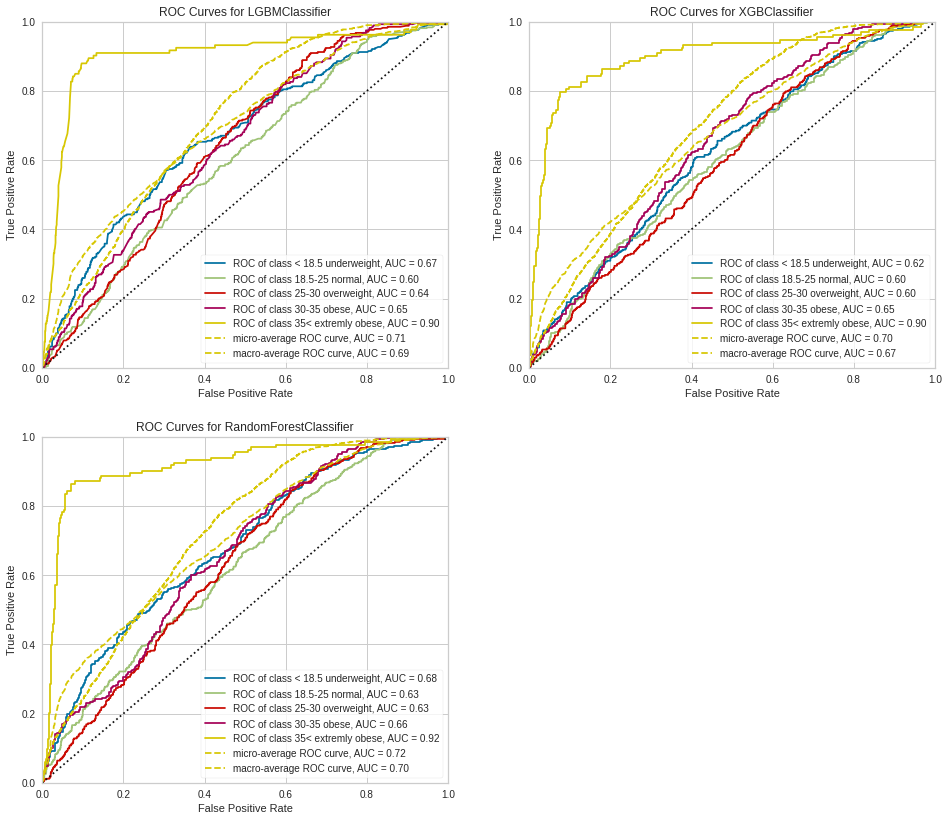

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))


visualgrid = [
    ROCAUC(
        lgbm_bmi,
        classes=[
            "< 18.5 underweight",
            "18.5-25 normal",
            "25-30 overweight",
            "30-35 obese",
            "35< extremly obese",
        ],
        ax=axes[0][0],
    ),
    ROCAUC(
        xgb_bmi,
        classes=[
            "< 18.5 underweight",
            "18.5-25 normal",
            "25-30 overweight",
            "30-35 obese",
            "35< extremly obese",
        ],
        ax=axes[0][1],
    ),
    ROCAUC(
        forest_bmi,
        classes=[
            "< 18.5 underweight",
            "18.5-25 normal",
            "25-30 overweight",
            "30-35 obese",
            "35< extremly obese",
        ],
        ax=axes[1][0],
    ),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
axes[-1, -1].axis("off")
plt.show()

According to all metrics the Random forest performance is best and this model was choosen for telegram bot implimintation.

# Conclusion

* BMI is not the best indicator for assessing people's health, but at the same time it has one of the biggest impacts on the outcome of forecasting
* Older people have bigger risk of getting stroke, same results were demonstrated by our model
* Men are more at risk of stroke
* The assumption that living in the country can have a positive impact on your health may be true, as the results showed that people in urban areas are at greater risk
* Of course, low glucose is also harmful to human health, but it does not put you at risk of stroke compared to high glucose levels
* Marriage has a negative impact on your BMI
* We have calculated that people working in the goverment sector are more at risk of heart disease
* Smokers have more cases of stroke
* Same as stroke, hypertension more afects older people
* Age and bmi have strong correlation
* In most cases, LGBM models were performed better than others
* Most import metric was f1 score in this case
* We were more focuse of class 1 
* Best model for predicting BMI was Random forest
* In totatl 4 models were built.
* Despite the fact that using SMOTE with reinforced models is not a good practice, LGBM has achieved the best results with its help.